<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setting" data-toc-modified-id="Setting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setting</a></span><ul class="toc-item"><li><span><a href="#Path" data-toc-modified-id="Path-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Path</a></span></li></ul></li><li><span><a href="#時系列データ作成" data-toc-modified-id="時系列データ作成-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>時系列データ作成</a></span><ul class="toc-item"><li><span><a href="#No-Noise" data-toc-modified-id="No-Noise-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>No Noise</a></span></li><li><span><a href="#Noise" data-toc-modified-id="Noise-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Noise</a></span></li></ul></li><li><span><a href="#入力データ作成" data-toc-modified-id="入力データ作成-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>入力データ作成</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Fit" data-toc-modified-id="Fit-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Fit</a></span></li></ul></li><li><span><a href="#Save-Model" data-toc-modified-id="Save-Model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Save Model</a></span></li></ul></li><li><span><a href="#history" data-toc-modified-id="history-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>history</a></span></li></ul></div>

# 一次元データ_Conv1d_重み可視化__sinFunc.ipynb

0. データ作成
  - 単なるsin関数を含んだ式
  - ノイズを加える
  - 異常波形作成
0. CNN時系列予測
  - [時系列予測を一次元畳み込みを使って解く with Keras - Qiita
      ](https://qiita.com/niisan-tokyo/items/a94dbd3134219f19cab1)
  - その背景を $windowsize$ 5-60程度で予測するConv1d層の作成
0. LSTMによる異常検出？
  - Conv1dで畳み込んだあとでLSTM層にぶち込めばよい？
  - LSTM層では異常かそうでないかの判別
    - 簡単にするために $\textbf{正常}:\textbf{異常}=1:1$ とするのが良さそう

In [38]:
ipynb_title = "create_Conv1d_model__SinCosFunc"

In [39]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path

import keras
print("Keras version : ", keras.__version__)

Keras version :  2.1.6


## Setting

### Path

In [40]:
HOME = Path(os.getcwd()).parent
print(HOME)
path_list = []

/home/pollen/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku


In [41]:
keras_model_h5_Path = HOME / "keras_model_h5_Path"
path_list.append(keras_model_h5_Path)

for _Path in path_list:
    _path = str(keras_model_h5_Path)
    if not os.path.exists(_path):
        os.makedirs(name=_path)
        print("make a directory: \n\t", _path)
    else:
        print(os.path.exists(_path), ": ", _path)

True :  /home/pollen/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku/keras_model_h5_Path


## 時系列データ作成

$$
\textbf{toy_func(t)} = 
  20 \cdot \left( 
    \sin\left( \frac{2\pi}{T} t \right)
    + \cos\left( 2 \cdot \frac{2\pi}{T} t \right)
    + \sin\left( 3 \cdot \frac{2\pi}{T} t \right)
    + \cos\left( 4 \cdot \frac{2\pi}{T} t \right)
  \right)
  + \frac{1}{5} t
  + \varepsilon
$$

In [42]:
def mySin(t, period=100):
    """
    時刻t, 周期period
    """
    return np.sin(2.0 * np.pi * t/period)

def myCos(t, period=100):
    """
    時刻t, 周期period
    """
    return np.cos(2.0 * np.pi * t/period)

### No Noise

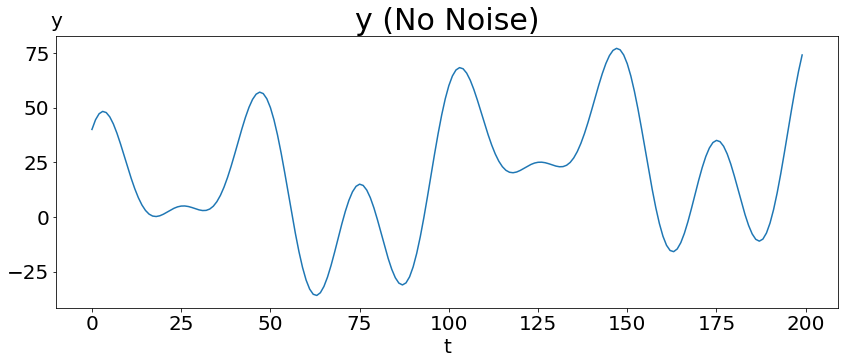

In [43]:
# No Noise
t = np.arange(start=0, stop=200, step=1)
triAmpl = 20
tAmpl = 0.2
y = triAmpl * ( mySin(t, period=100)
                + mySin(t=3*t, period=100)
                + myCos(t=2*t, period=100)
                + myCos(t=4*t, period=100) ) + tAmpl * t

#----------
# Plot
#----------
fig = plt.figure(figsize=(14,5))  # (width, height)
ax = fig.add_subplot(1,1,1)

ax.plot(t, y)

title = "y (No Noise)"
ax.set_title(label=title, fontsize=30)
ax.set_xlabel(xlabel="t", fontsize=20)
ax.set_ylabel(ylabel="y", fontsize=20, rotation=0)
ax.yaxis.set_label_coords(x=0., y=1.02)
ax.tick_params(labelsize=20)

plt.show()

### Noise

In [44]:
# Add Noise
def toy_func(tStart=0, tStop=100, tStep=1, triAmpl=20, tAmpl=0.5, noiseAmpl=0.05):
    """
    T : 
      sin波の周期
    ampl : 
      ノイズ振幅調整
      """
    t = np.arange(start=tStart, stop=tStop, step=tStep)
    noise = noiseAmpl * np.random.randn(t.shape[0])  # mean=0, standard_deviation=1
    return (t,
            triAmpl * ( mySin(t, period=100)
                        + mySin(t=3*t, period=100)
                        + myCos(t=2*t, period=100)
                        + myCos(t=4*t, period=100) )
            #+ tAmpl * t
            + noise )

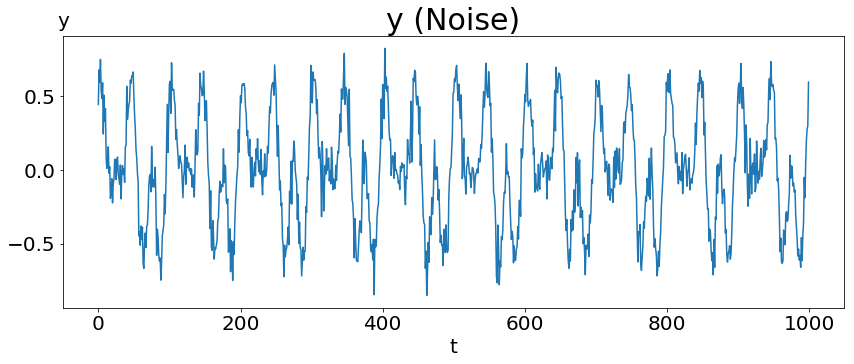

In [45]:
fig = plt.figure(figsize=(14,5))  # (width, height)
ax = fig.add_subplot(1,1,1)
t, y = toy_func(tStop=1000, triAmpl=1./4, tAmpl=0.0, noiseAmpl=0.1)
ax.plot(t, y)

title = "y (Noise)"
ax.set_title(label=title, fontsize=30)
ax.set_xlabel(xlabel="t", fontsize=20)
ax.set_ylabel(ylabel="y", fontsize=20, rotation=0)
ax.yaxis.set_label_coords(x=0.0, y=1.02)
ax.tick_params(labelsize=20)

plt.show()

## 入力データ作成

In [46]:
windowsize = 60
predictsize = 1
sample_data_size = 10000
trainsize = 10000

In [47]:
_, sample_wave = toy_func(tStop=sample_data_size, triAmpl=1./4, tAmpl=0.0, noiseAmpl=0.1)
print(sample_wave.shape)

(10000,)


In [48]:
input_data  = np.empty(shape=(0, windowsize))
output_data = np.empty(shape=(0, predictsize))
print(input_data.shape)
print(output_data.shape)
for i in range( sample_wave.shape[0] - (windowsize + predictsize) + 1 ):
    input_data = np.append(arr=input_data,
                           values=sample_wave[i:(i+windowsize)].reshape(1, -1),
                           axis=0)
    output_data = np.append(arr=output_data,
                            values=sample_wave[(i+windowsize):(i+windowsize+predictsize)].reshape(1, -1),
                            axis=0)
print("input_data.shape  : ", input_data.shape)
print("output_data.shape : ", output_data.shape)
input_data = input_data.reshape((-1, windowsize, 1))
output_data = output_data.reshape((-1, predictsize, 1))
print("input_data.shape  : ", input_data.shape)
print("output_data.shape : ", output_data.shape)

(0, 60)
(0, 1)
input_data.shape  :  (9940, 60)
output_data.shape :  (9940, 1)
input_data.shape  :  (9940, 60, 1)
output_data.shape :  (9940, 1, 1)


In [49]:
train_x, test_x = input_data[:trainsize], input_data[trainsize:]
train_y, test_y = output_data[:trainsize], output_data[trainsize:]
print("train_x.shape : ", train_x.shape)
print("train_y.shape : ", train_y.shape)
print("test_x.shape  : ", test_x.shape)
print("test_y.shape  : ", test_y.shape)

train_x.shape :  (9940, 60, 1)
train_y.shape :  (9940, 1, 1)
test_x.shape  :  (0, 60, 1)
test_y.shape  :  (0, 1, 1)


## Model

- Conv1d
  - https://keras.io/ja/layers/convolutional/#conv1d
- 正則化
  - https://keras.io/ja/regularizers/
  

In [50]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.convolutional import Conv1D, UpSampling1D
from keras.layers.pooling import MaxPooling1D
from keras import regularizers

In [51]:
model = Sequential()
model.add( Conv1D(filters=windowsize, kernel_size=10, strides=1, padding="same",
                  activation="relu",
                  #kernel_regularizer=regularizers.l2(0.1),
                  #bias_regularizer=regularizers.l2(0.1),
                  input_shape=(windowsize, 1),
                  ) )
model.add( MaxPooling1D(pool_size=2, padding="same") )
model.add( Conv1D(filters=windowsize, kernel_size=10, padding='same', activation='relu',
                  #kernel_regularizer=regularizers.l2(0.1),
                  #bias_regularizer=regularizers.l2(0.0),
                  ) )
model.add( MaxPooling1D(pool_size=5, padding='same') )
model.add( Conv1D(filters=int(windowsize/2), kernel_size=10, padding='same', activation='relu',
                  #kernel_regularizer=regularizers.l2(0.1),
                  #bias_regularizer=regularizers.l2(0.1),
                  ) )
model.add( MaxPooling1D(pool_size=6, padding='same') )
model.add( Conv1D(filters=int(windowsize/2/2), kernel_size=10, padding='same', activation='relu',
                  #kernel_regularizer=regularizers.l2(0.1),
                  #bias_regularizer=regularizers.l2(0.1),
                  ) )
model.add( Conv1D(filters=1, kernel_size=8, padding='same', activation='tanh',
                  #kernel_regularizer=regularizers.l2(0.1),
                  #bias_regularizer=regularizers.l2(0.1),
                  ) )

model.compile(loss='mse', optimizer='adam')

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 60, 60)            660       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 30, 60)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 30, 60)            36060     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 6, 60)             0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 6, 30)             18030     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1, 30)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 15)             4515      
__________

#### Fit

In [53]:
epochs = 200
history = model.fit(x=train_x,
                    y=train_y,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8946 samples, validate on 994 samples
Epoch 1/200
8946/8946 [==============================] - 3s 363us/step - loss: 0.0227 - val_loss: 0.0123
Epoch 2/200
8946/8946 [==============================] - 3s 339us/step - loss: 0.0115 - val_loss: 0.0119
Epoch 3/200
8946/8946 [==============================] - 3s 342us/step - loss: 0.0113 - val_loss: 0.0116
Epoch 4/200
8946/8946 [==============================] - 5s 534us/step - loss: 0.0113 - val_loss: 0.0126
Epoch 5/200
8946/8946 [==============================] - 3s 372us/step - loss: 0.0110 - val_loss: 0.0122
Epoch 6/200
8946/8946 [==============================] - 5s 577us/step - loss: 0.0108 - val_loss: 0.0117
Epoch 7/200
8946/8946 [==============================] - 3s 352us/step - loss: 0.0108 - val_loss: 0.0119
Epoch 8/200
8946/8946 [==============================] - 3s 336us/step - loss: 0.0107 - val_loss: 0.0115
Epoch 9/200
8946/8946 [==============================] - 3s 339us/step - loss: 0.0108 - val_loss: 0.0115
Epoch 10

Epoch 78/200
8946/8946 [==============================] - 3s 337us/step - loss: 9.5267e-04 - val_loss: 0.0182
Epoch 79/200
8946/8946 [==============================] - 3s 321us/step - loss: 9.4060e-04 - val_loss: 0.0178
Epoch 80/200
8946/8946 [==============================] - 3s 336us/step - loss: 8.9067e-04 - val_loss: 0.0180
Epoch 81/200
8946/8946 [==============================] - 3s 329us/step - loss: 7.4901e-04 - val_loss: 0.0180
Epoch 82/200
8946/8946 [==============================] - 3s 314us/step - loss: 8.1512e-04 - val_loss: 0.0181
Epoch 83/200
8946/8946 [==============================] - 3s 335us/step - loss: 8.3934e-04 - val_loss: 0.0187
Epoch 84/200
8946/8946 [==============================] - 3s 322us/step - loss: 7.9281e-04 - val_loss: 0.0176
Epoch 85/200
8946/8946 [==============================] - 3s 322us/step - loss: 8.3614e-04 - val_loss: 0.0179
Epoch 86/200
8946/8946 [==============================] - 3s 347us/step - loss: 7.4429e-04 - val_loss: 0.0178
Epoch 87/2

8946/8946 [==============================] - 3s 309us/step - loss: 4.0121e-04 - val_loss: 0.0169
Epoch 153/200
8946/8946 [==============================] - 3s 322us/step - loss: 4.2453e-04 - val_loss: 0.0172
Epoch 154/200
8946/8946 [==============================] - 3s 379us/step - loss: 4.2160e-04 - val_loss: 0.0170
Epoch 155/200
8946/8946 [==============================] - 4s 484us/step - loss: 4.1510e-04 - val_loss: 0.0173
Epoch 156/200
8946/8946 [==============================] - 3s 327us/step - loss: 3.7322e-04 - val_loss: 0.0170
Epoch 157/200
8946/8946 [==============================] - 3s 318us/step - loss: 3.3018e-04 - val_loss: 0.0168
Epoch 158/200
8946/8946 [==============================] - 5s 525us/step - loss: 3.8553e-04 - val_loss: 0.0173
Epoch 159/200
8946/8946 [==============================] - 3s 318us/step - loss: 4.5382e-04 - val_loss: 0.0172
Epoch 160/200
8946/8946 [==============================] - 3s 312us/step - loss: 4.1835e-04 - val_loss: 0.0171
Epoch 161/200
8

### Save Model

In [54]:
modelpath = str(keras_model_h5_Path / ("model__" + ipynb_title + ".h5"))
model.save(filepath=modelpath)

## history

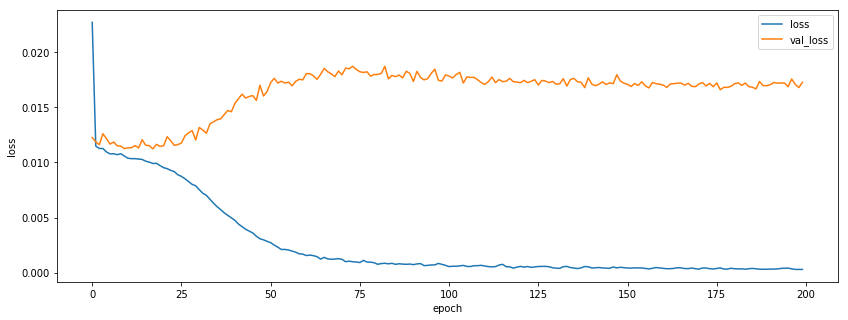

In [55]:
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1,1,1)

ax.plot(range(epochs), history.history['loss'], label='loss')
ax.plot(range(epochs), history.history['val_loss'], label='val_loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend() 

plt.show()

# End